In [1]:
from matplotlib.colors import NoNorm
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import math
from matplotlib import pyplot as plt
import ternary

In [2]:
def check_data(data):
    # Mask invalid data
    data[data <= -999] = 0
    return data

def normalize_data(data):
    # Normalize data to range [0, 1]
    data_min, data_max = np.nanmin(data), np.nanmax(data)
    return (data - data_min) / (data_max - data_min)

def color_point(x, y, z):
    r = 1- x
    g = 1- y
    b = 1- z
    result =np.dstack((r, g, b))
    return result

def draw_ternary_map(in_tif1, in_tif2, in_tif3, outfig):
    # Open the datasets
    ds1 = gdal.Open(in_tif1)
    ds2 = gdal.Open(in_tif2)
    ds3 = gdal.Open(in_tif3)

    # Read the datasets as arrays
    data1 = check_data(ds1.ReadAsArray())
    data2 = check_data(ds2.ReadAsArray())
    data3 = check_data(ds3.ReadAsArray())

    
    # Get geotransform and calculate extent
    geotransform = ds1.GetGeoTransform()
    originX = geotransform[0] # 左上角x坐标
    originY = geotransform[3] # 左上角y坐标维度
    pixelWidth = geotransform[1] # 东西方向像素分辨率
    pixelHeight = geotransform[5] # 南北方向像素分辨率
    extents = [originX, originX + (pixelWidth * ds1.RasterXSize), 
                originY + (pixelHeight * ds1.RasterYSize),originY]

    # Plot
    proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(8, 8), dpi=600, subplot_kw={'projection': proj})

    # 创建一个与RGB数据相同形状的alpha通道，初始值设为1（不透明）
    alpha_channel = np.ones_like(data1)

    # 在数据中有NaN值的地方，将alpha通道设置为0（透明）
    alpha_channel[np.isnan(data1)] = 0
    alpha_channel[np.isnan(data2)] = 0
    alpha_channel[np.isnan(data3)] = 0

    # Stack arrays along the last dimension to create an RGB image
    rgb = color_point(data1, data2, data3)
    rgba = np.dstack((rgb, alpha_channel))
    # Plot the RGB image
    ax.imshow(rgba, origin='upper', extent=extents,transform=ccrs.PlateCarree())

    # Add features and boundaries
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='w', lw=0.5)
   
    # 添加省边界和十段线
    province = shpreader.Reader('省.shp')
    nineline = shpreader.Reader('十段线.shp')
    ax.add_geometries(province.geometries(), crs=ccrs.PlateCarree(), edgecolor='k',facecolor='none')
    ax.add_geometries(nineline.geometries(), crs=ccrs.PlateCarree(), edgecolor='k',facecolor='none')


    # 设置大刻度和小刻度
    ax.set_xticks(np.arange(80, 140, 20), crs=proj)
    ax.set_xticks(np.arange(80, 140, 10), minor=True, crs=proj)
    ax.set_yticks(np.arange(20, 70, 20), crs=proj)
    ax.set_yticks(np.arange(20, 70, 10), minor=True, crs=proj)

    # 利用Formatter格式化刻度标签
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    ax2 = fig.add_axes([0.76, 0.25, 0.12, 0.18], projection = proj)
    ax2.set_extent([104.5, 125, 0, 26])

    ax2.imshow(rgba, origin='upper', extent=extents,transform=ccrs.PlateCarree())
    ax2.add_feature(cfeature.LAND, edgecolor='black',facecolor='w',lw=0.4)
    
    ax2.add_geometries(province.geometries(), crs=ccrs.PlateCarree(), edgecolor='k',facecolor='none',lw=0.4)
    ax2.add_geometries(nineline.geometries(), crs=ccrs.PlateCarree(), edgecolor='k',facecolor='none',lw=0.4)
    
    # 设置大刻度和小刻度
    ax2.set_xticks(np.arange(110, 121, 10), crs=proj)
    ax2.set_yticks(np.arange(5, 25, 10), crs=proj)
    ax2.xaxis.set_major_formatter(LongitudeFormatter())
    ax2.yaxis.set_major_formatter(LatitudeFormatter())
    ax2.tick_params(axis='both', length=2, pad=0.5, labelcolor='k', width=0.5, labelsize=8)
    ax2.xaxis.set_ticks_position('top')
    # Save the figure
    plt.savefig(outfig, dpi=600)
    plt.show()

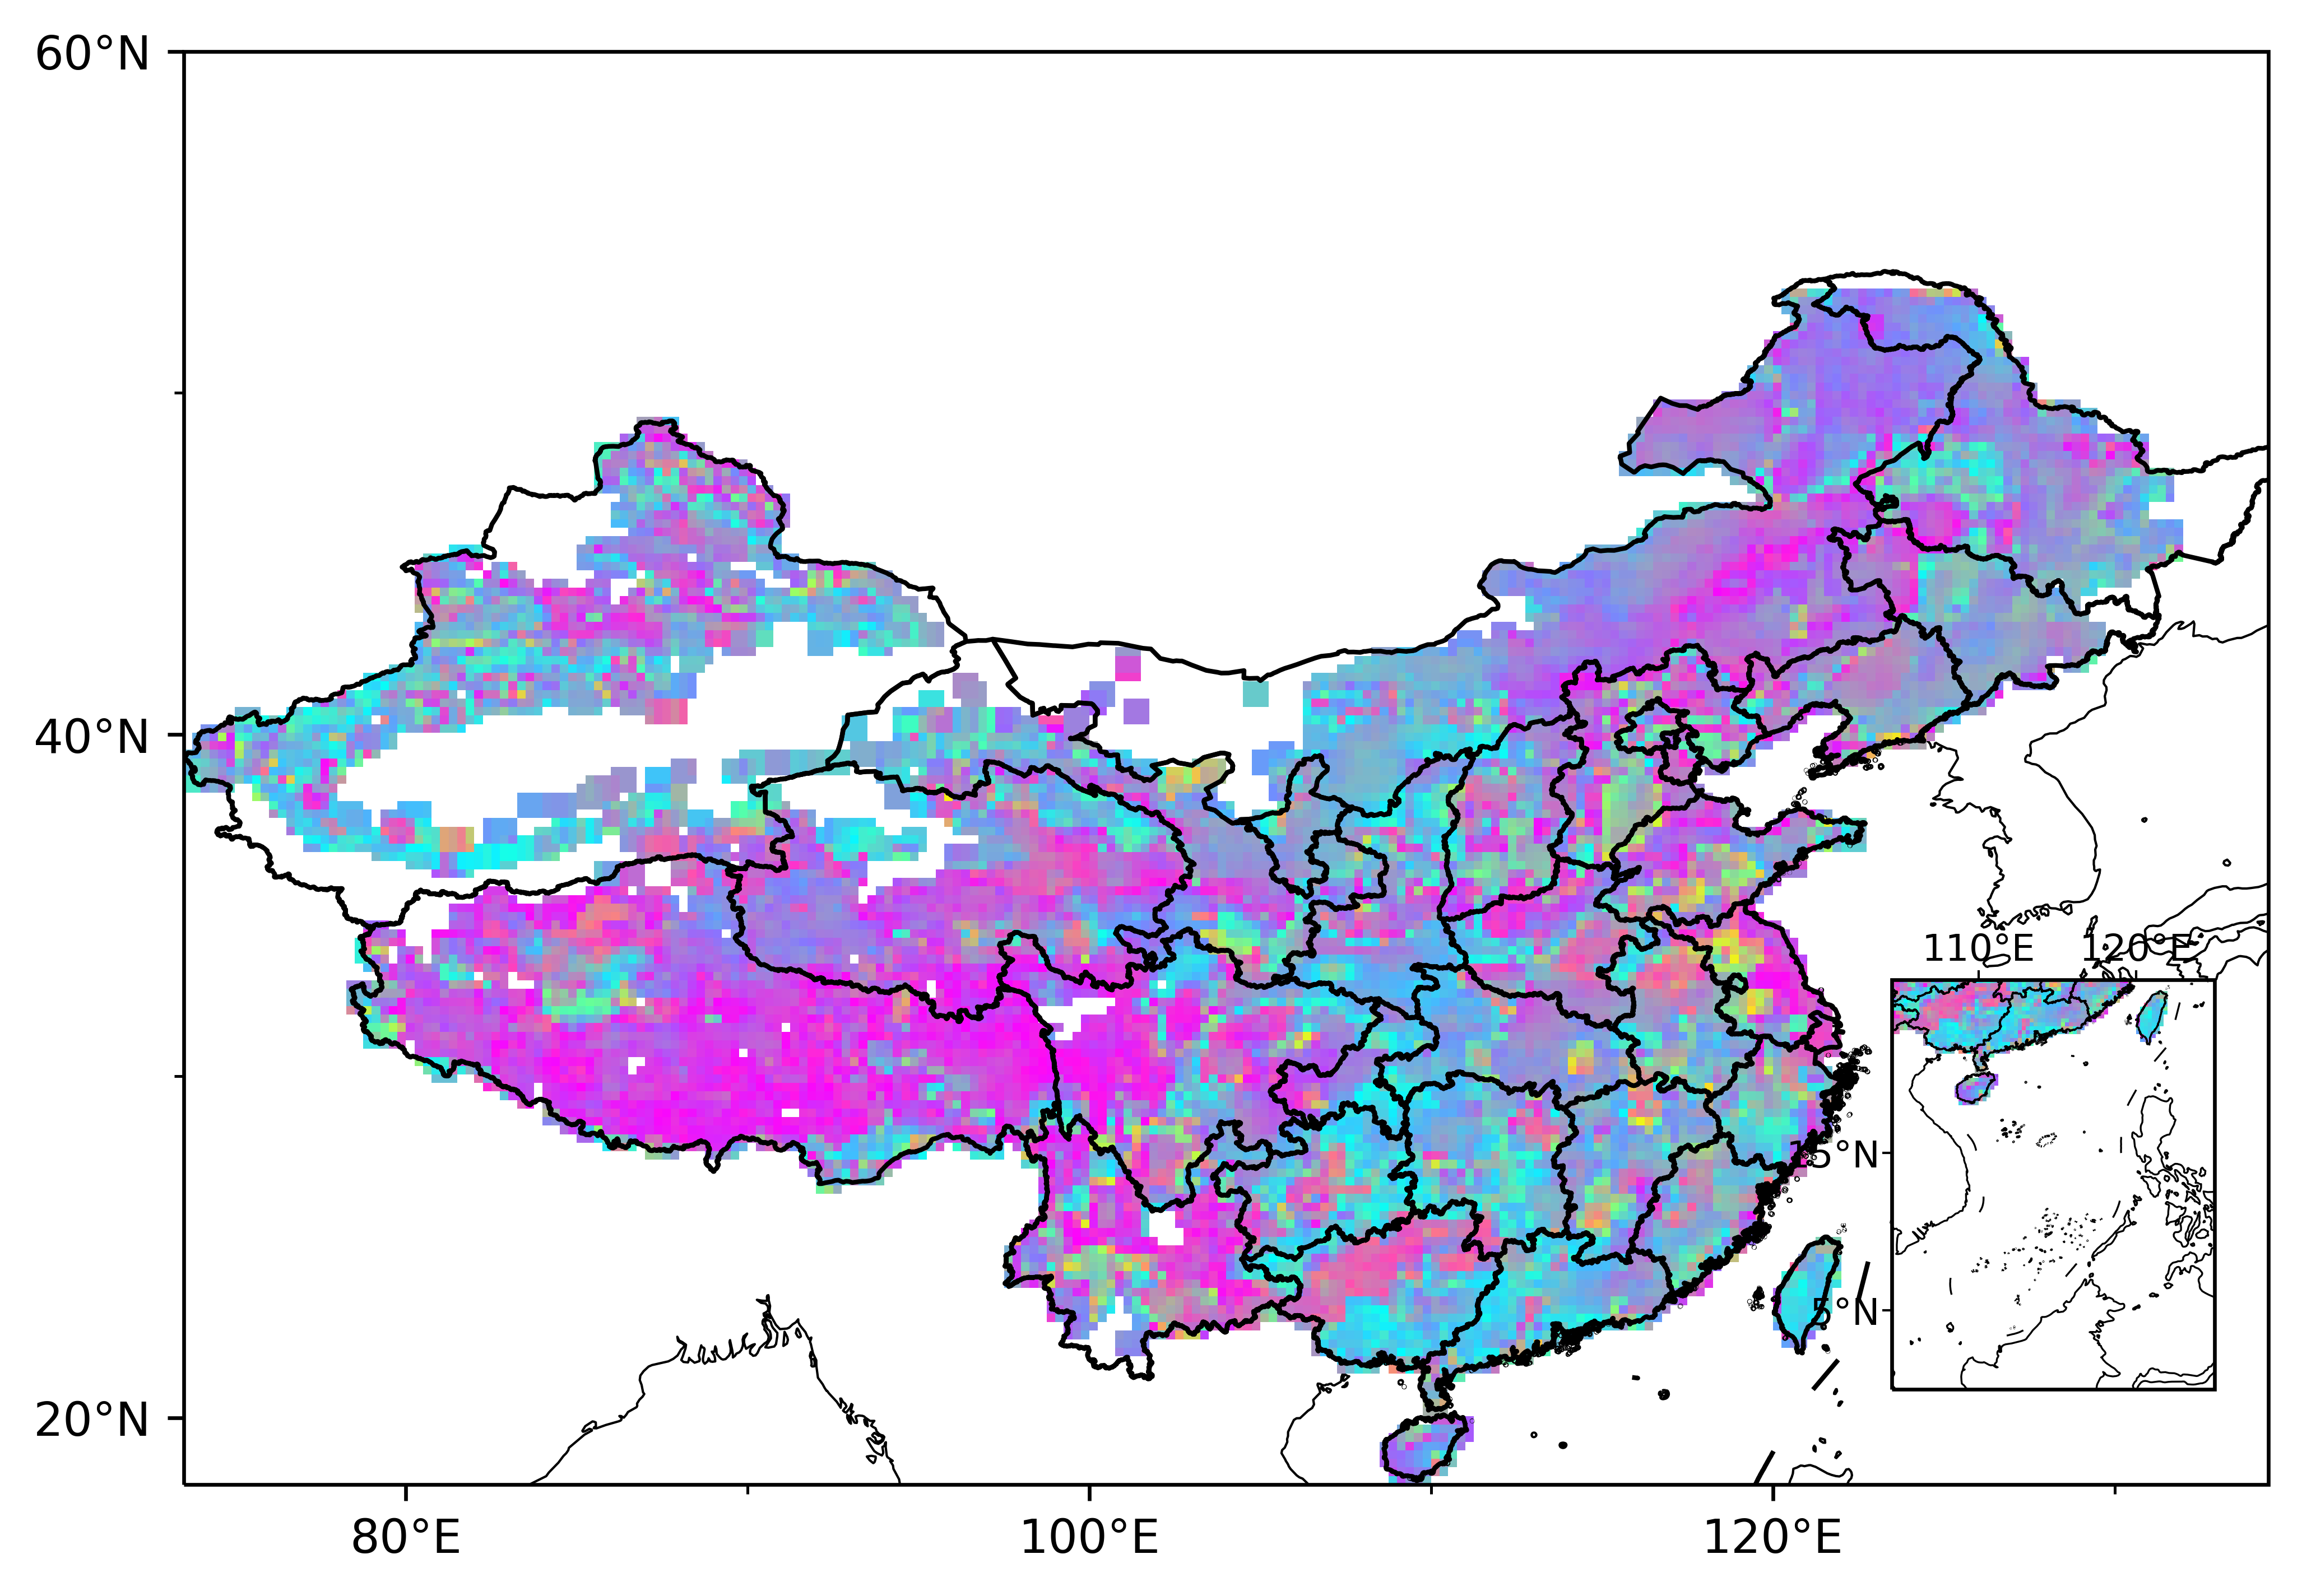

In [3]:
tif_1 = 'factor1.tif'
tif_2 = 'factor2.tif'
tif_3 = 'factor3.tif'
out_fig = 'out_fig.jpg'
# Example usage
draw_ternary_map(tif_1,tif_2,tif_3,out_fig)


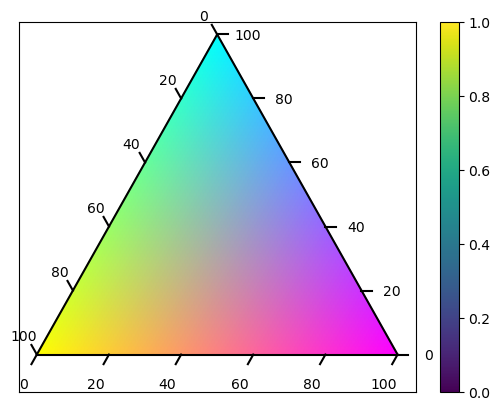

In [9]:
def color_point(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    r = math.fabs(w - y_color) / w
    g = math.fabs(w - x_color) / w
    b = math.fabs(w - z_color) / w
    return (r, g, b, 1.)


def generate_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point(i, j, k, scale)
    return d


scale = 100
data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="hexagonal", use_rgba=True)
tax.boundary()

# 设置刻度的偏移量
tax.ticks(axis='lbr', multiple=20, clockwise=False, offset=0.03)
# 隐藏matplotlib的刻度和边框
tax.clear_matplotlib_ticks()
plt.show()
